In [1]:
%load_ext autoreload
%autoreload 2

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit import QuantumCircuit

In [4]:
from qml.model.gate import get_gateset
from qml.model.unit import Unit, EmbedUnit
from qml.model.model import Model
from qml.tools.trainer import calc_gradients
from qml.tools.dataloader import DataLoader

In [26]:
np.set_printoptions(precision=3, floatmode='fixed')

In [5]:
nq = 2
nx = 1
ng = 3
gateset = get_gateset(nq)

In [6]:
enb_unit = EmbedUnit.generate_ry_arcsin_embed_unit("emb", nq, nx, gateset)

In [7]:
target_fn = lambda x: np.sin(np.pi * x)

In [12]:
train_xs = np.random.uniform(-1, 1, 20)
train_ys = target_fn(train_xs)

test_xs = np.random.uniform(-1, 1, 20)
test_ys = target_fn(test_xs)

In [18]:
train_loader = DataLoader(train_xs, train_ys, 5)
test_loader = DataLoader(test_xs, test_ys, len(test_xs))

In [37]:
model = Model(nq, 1, enb_unit, [], [], shots=50)
ps = [model.forward(x) for x in test_xs]

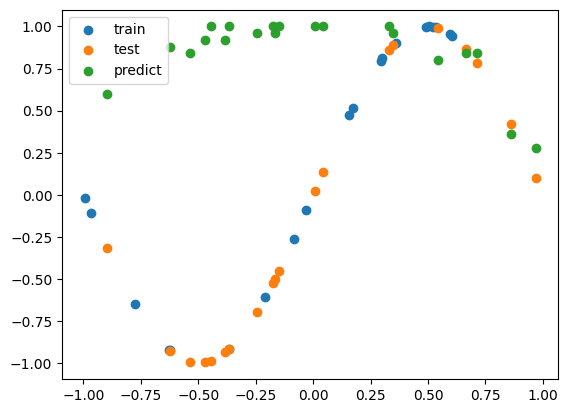

In [38]:
fig, ax = plt.subplots()
ax.scatter(train_xs, train_ys, label="train")
ax.scatter(test_xs, test_ys, label="test")
ax.scatter(test_xs, ps, label="predict")
plt.legend()
plt.show()

In [77]:
nstep = 30
lr = 1e-1

In [78]:
tr_unit = Unit.generate_random_unit("tr_unit_0", nq, ng, gateset)

In [79]:
model = Model(nq, 1, enb_unit, [], [tr_unit], shots=50)

In [80]:
model.trainable_parameters

[array([0.0, 0.0], dtype=object)]

step  30, loss  0.434
updated: [array([6.278003866950621, 0.006383997455017956], dtype=object)]


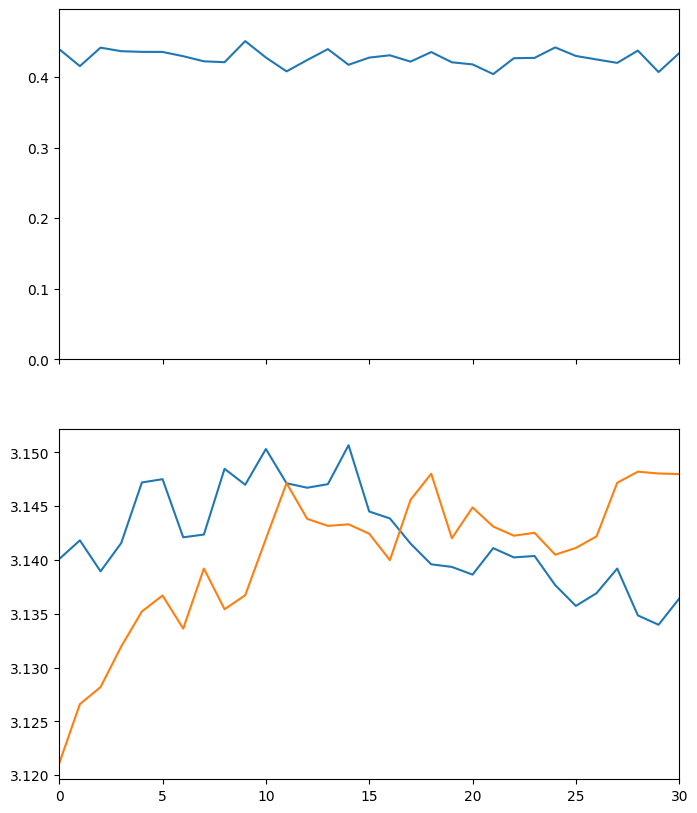

In [86]:
log_step = []
log_loss = []
log_params = []

loss = np.mean([
    0.5 * np.square(y - model.forward(x))
    for x, y in zip(train_xs, train_ys)
])
log_step.append(0)
log_loss.append(loss)
log_params.append(np.asarray(model.trainable_parameters).flatten())

for step in range(1, nstep + 1):
    epoch_loss = 0
    for batch_xs, batch_ys in train_loader:
        predicts = np.asarray([
            model.forward(x)
            for x in batch_xs
        ])
        errors = batch_ys - predicts
        losses = np.square(errors) * 0.5
        gradients = np.asarray([
            calc_gradients(model, x)
            for x in batch_xs
        ])
        errors_reshaped = errors.reshape((len(batch_xs), -1, 1))
        dlosses = gradients * errors_reshaped
        dparams = dlosses.mean(axis=0)
        new_params = [
            param - lr * dparam
            for param, dparam in zip(model.trainable_parameters, dparams)
        ]
        model.update_parameters(new_params)
        
        epoch_loss += np.sum(losses)
    epoch_loss /= train_loader.size
    log_step.append(step)
    log_loss.append(epoch_loss)
    log_params.append(np.asarray(model.trainable_parameters).flatten())
    
    clear_output()
    print(f"step {step: 3d}, loss {epoch_loss:6.3f}")
    print("updated:", model.trainable_parameters)
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(8, 10))
    axes[0].plot(log_step, log_loss)
    axes[0].set_xlim(0, step)
    axes[0].set_ylim(0, np.max(log_loss) * 1.1)
    np_log_params = (np.asarray(log_params).T + np.pi) % (2 * np.pi)
    for i in range(np_log_params.shape[0]):
        axes[1].plot(log_step, np_log_params[i, ...])
    plt.show()

In [103]:
def evaluate(model, loader, params=None, shots=None):
    def _eval_one(x, y):
        pre = model.forward(x, params=params, shots=shots)
        error = y - pre
        loss = 0.5 * (error ** 2)
        return loss

    losses = [
        _eval_one(bx[0], by[0])
        for bx, by in loader
    ]
    return np.mean(losses)
    

candidate_#:  0, loss:  0.455
candidate_#:  1, loss:  0.442
candidate_#:  2, loss:  0.426
candidate_#:  3, loss:  0.423
candidate_#:  4, loss:  0.408


In [ ]:
train_loader = DataLoader(train_xs, train_ys, 1)
tr_unit = Unit.generate_random_unit("tr_unit_0", nq, ng, gateset)
model = Model(nq, 1, enb_unit, [], [tr_unit], shots=50)
param_shape = np.asarray(model.trainable_parameters).shape

In [111]:
candidates = []
losses = []
for i in range(20):
    params_candidate = np.random.random(param_shape) * 2 * np.pi
    evaluate(model, train_loader, params=params_candidate)
    loss = evaluate(model, train_loader, params=params_candidate)
    
    print(f"candidate_#: {i:2d}, loss: {loss:6.3f}")
    candidates.append(params_candidate)
    losses.append(loss)

candidate_#:  0, loss:  0.437
candidate_#:  1, loss:  0.442
candidate_#:  2, loss:  0.412
candidate_#:  3, loss:  0.430
candidate_#:  4, loss:  0.402
candidate_#:  5, loss:  0.416
candidate_#:  6, loss:  0.457
candidate_#:  7, loss:  0.428
candidate_#:  8, loss:  0.433
candidate_#:  9, loss:  0.444
candidate_#:  10, loss:  0.418
candidate_#:  11, loss:  0.440
candidate_#:  12, loss:  0.432
candidate_#:  13, loss:  0.433
candidate_#:  14, loss:  0.395
candidate_#:  15, loss:  0.418
candidate_#:  16, loss:  0.414
candidate_#:  17, loss:  0.395
candidate_#:  18, loss:  0.430
candidate_#:  19, loss:  0.429


In [112]:
np_candidates = np.squeeze(candidates)
np_losses = np.squeeze(losses)

(0.0, 6.283185307179586)

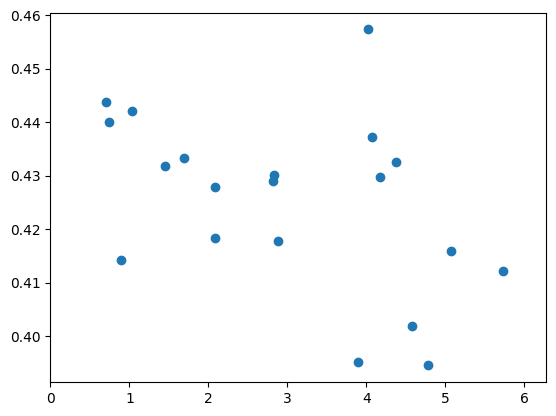

In [113]:
plt.scatter(np_candidates, np_losses)
plt.xlim(0, np.pi * 2)

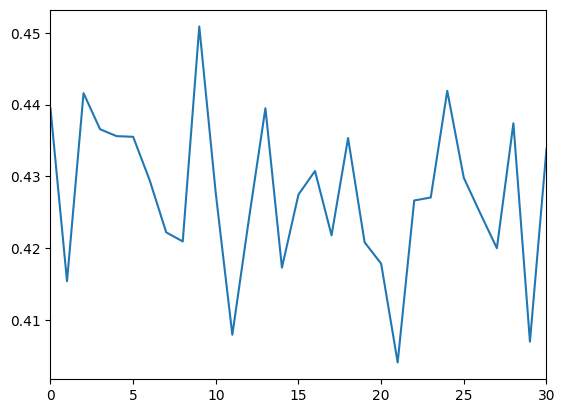

In [115]:
plt.plot(log_step, log_loss)
plt.xlim(0, np.max(log_step))
# plt.ylim(0, np.max(log_loss)*1.1)
plt.show()